In [71]:
import zarr
import h5py
import matplotlib.pyplot as plt
from midasmednet.unet.loss import compute_per_channel_dice, expand_as_one_hot
import torch
import numpy as np
import nibabel as nib
from pathlib import Path
from skimage.measure import label 

In [100]:
#data_path = '/mnt/qdata/raheppt1/data/tumorvolume/interim/ctorgans/ctorgans.h5' 
data_path = '/mnt/qdata/raheppt1/data/tumorvolume/interim/petbc/TUE0000ALLDS_3D.h5'
#prediction_path = '/mnt/qdata/raheppt1/ctorgans.zip'
prediction_path = '/mnt/qdata/raheppt1/data/tumorvolume/processed/ctorgans/ctorgans_petct.zip'
out_dir = Path('/mnt/qdata/raheppt1/data/tumorvolume/processed/ctorgans/validation')

In [141]:
# get key list
with zarr.open(store=zarr.ZipStore(prediction_path, mode='r')) as zf:
    keys = list(zf['prediction'])
key = keys[10]

In [142]:
# load predictions
with zarr.open(store=zarr.ZipStore(prediction_path, mode='r')) as zf:
    mask_predicted = zf[f'prediction/{key}'][0, :]

In [143]:
# load training data
with h5py.File(data_path, 'r') as hf:
    ds = hf[f'image/{key}']
    img = ds[1,:].astype(np.float32)
    pet = ds[0,:].astype(np.float32)

In [144]:
def largest_component(one_hot_mask):
    # mask as one hot encoded CxHxWxD
    # select largest component
    pp_mask = []
    for channel in range(len(one_hot_mask)):
        mask = one_hot_mask[channel, ...]
        mask_l, num_of_comp  = label(mask, return_num=True)
        if num_of_comp > 0:
            comp_size = [(mask_l==c).sum() for c in range(num_of_comp + 1)]
            largest_comp = np.argmax(comp_size[1:]) + 1
            mask_l = (mask_l==largest_comp).astype(np.uint8)
            pp_mask.append(mask_l)
        else:
            pp_mask.append(mask)
    pp_mask = np.stack(pp_mask, axis=0)
    return pp_mask            

In [145]:
# postprocess
oh_mask_predicted = expand_as_one_hot(torch.tensor(mask_predicted[np.newaxis, ...]).long(), C=4)
oh_mask_predicted_pp = largest_component(oh_mask_predicted.numpy()[0,...])
mask_predicted_pp = np.argmax(oh_mask_predicted_pp, axis=0)
oh_mask_predicted_pp = torch.tensor(oh_mask_predicted_pp[np.newaxis, ...])

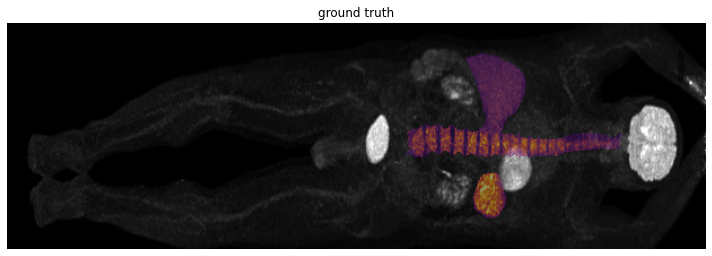

In [146]:
fig, ax = plt.subplots(figsize=[10,15])
ax.title.set_text('ground truth')
ax.imshow(pet.max(axis=1), cmap='gray', vmin=0.0, vmax=0.4)
ax.axis('off')
mip = (pet*mask_predicted).max(axis=1)
mip = np.ma.array(mip, mask=(mip==0))
ax.imshow(mip, alpha=0.5, cmap='inferno', vmin=0.0, vmax=0.2 )
plt.tight_layout()

In [20]:
data_path = '/mnt/qdata/raheppt1/data/tumorvolume/interim/ctorgans/ctorgans.h5' 
with h5py.File(data_path, 'r') as hf:
    keys = list(hf['images'])
out_dir = Path('/mnt/qdata/raheppt1/data/tumorvolume/test/nifti/ctorgans')
print(keys)

['002', '003', '004', '005', '006', '007', '008', '009', '010', '013', '014', '015', '016', '017', '018', '019', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '035', '036', '037', '038', '039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049', '051', '052', '053', '055', '056', '057', '058']


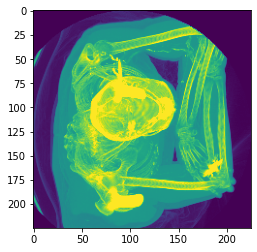

In [22]:
import nibabel as nib
with h5py.File(data_path, 'r') as hf:
    for key in keys[5:6]:
        ds = hf[f'images/{key}']
        affine = ds.attrs['affine']
        img_ct = hf[f'images/{key}'][0, ...].astype(np.float32)
        img_ct = img_ct[:,:,:]
        plt.imshow(img_ct.max(axis=2))
        #nib.save(nib.Nifti1Image(img_ct, np.array(affine)), out_dir/f'ct_{key}.nii.gz')
        break

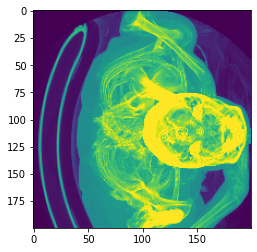

In [27]:
import nibabel as nib
with h5py.File('/mnt/qdata/raheppt1/data/tumorvolume/interim/petbc/TUE0000ALLDS_3D.h5', 'r') as hf:
    keys = list(hf['image'])
    for key in keys[5:6]:
        ds = hf[f'image/{key}']
        affine = ds.attrs['affine']
        img_ct = hf[f'image/{key}'][1, ...].astype(np.float32)
        img_ct = img_ct[:,:,:]
        plt.imshow(img_ct.max(axis=2))
        #nib.save(nib.Nifti1Image(img_ct, np.array(affine)), out_dir/f'ct_{key}.nii.gz')
        break